In [31]:
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import time
from pylab import *
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage.util.shape import view_as_windows
from sklearn.metrics import roc_curve,roc_auc_score
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Conv2D, Layer, Lambda, Flatten, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model, metrics
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
source = os.path.abspath(os.path.join('../../../data/LOB2VecData/Research/source'))
dest = os.path.abspath(os.path.join('../../../data/LOB2VecData/Research/destination'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
    
#np.set_printoptions(suppress=True)
#np.set_printoptions(threshold=sys.maxsize)

In [62]:
!pip install --user gast==0.3.3

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'


In [33]:
# Hyperparameters
cols, rows = 2, 30
num_frames = 500
input_shape = (cols, rows, 1)
vol_imb_diff = 0.1
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 100
n_iter = 20000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
h = 30
w = 2
d = 2
embeddingsize = 128
alpha1=1
alpha2=0.5
margin = 0.1
margin2 = 0.01

In [34]:
# Data
X_train = np.load(dest + '/' + str(num_frames) + '_small_X.npy')
Y_train = np.load(dest + '/' + str(num_frames) + '_small_X.npy')

X_test = np.load(dest + '/' + str(num_frames) + '_small_X.npy')
Y_test = np.load(dest + '/' + str(num_frames) + '_small_Y.npy')

### Model Initialisation

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

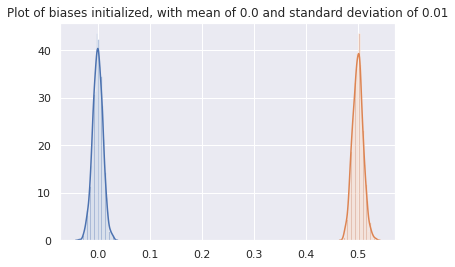

In [35]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [36]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    
class QuadrupletLossLayer(Layer):
    def __init__(self, alpha, beta, **kwargs):
        self.alpha = alpha
        self.beta = beta
        self.debugeric = 1
        super(QuadrupletLossLayer, self).__init__(**kwargs)
    
    def quadruplet_loss(self, inputs):
        anchor, positive, negative, negative2 = inputs
        ap_dist = K.sum(K.square(anchor-positive), axis=-1)
        an_dist = K.sum(K.square(anchor-negative), axis=-1)
        nn_dist = K.sum(K.square(negative-negative2), axis=-1)
        
        #square
        ap_dist2 = K.square(ap_dist)
        an_dist2 = K.square(an_dist)
        nn_dist2 = K.square(nn_dist)
        
        return K.sum(K.maximum(ap_dist2 - an_dist2 + self.alpha, 0), axis=0) + K.sum(K.maximum(ap_dist2 - nn_dist2 + self.beta, 0), axis=0)
    
    def call(self, inputs):
        loss = self.quadruplet_loss(inputs)
        self.add_loss(loss)
        return loss

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 500, 30, 2, 2)]   0         
_________________________________________________________________
lambda_15 (Lambda)           (None, 500, 120)          0         
_________________________________________

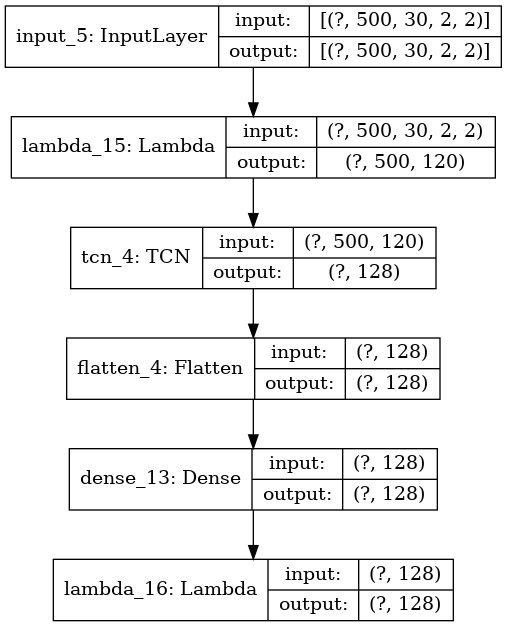

In [37]:
def embedding_model(frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None):  
    inp = Input(shape=(frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(inp)
    out = TCN(nb_filters=128, kernel_size=2, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32, 64], 
              activation=tf.keras.activations.swish, nb_stacks=1, dropout_rate=0.08)(out)
    out = Flatten()(out)
    out = Dense(128, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(out)   
    #Force the encoding to live on the d-dimentional hypershpere
    out = Lambda(lambda x: K.l2_normalize(x,axis=-1))(out)
    return Model(inputs=inp, outputs=out)

def triplets_model(input_shape, embedding, include_top=False, pooling=None):

    anchor_input = Input(shape=input_shape, name='anchor_input')
    positive_input = Input(shape=input_shape, name='positive_input')
    negative_input = Input(shape=input_shape, name='negative_input')

    # Get the embedded values
    encoded_a = embedding(anchor_input)
    encoded_p = embedding(positive_input)
    encoded_n = embedding(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    # Connect the inputs with the outputs
    triplet_net = Model(inputs=[anchor_input,positive_input,negative_input],outputs=[loss_layer])
    return triplet_net

build_embedding = embedding_model(num_frames, 30, w, d, input_shape=(num_frames, 30, w, d), dimensions=embeddingsize)
build_triplet = triplets_model(input_shape=(num_frames, 30, w, d), embedding=build_embedding)
optimizer = Adam(lr = 0.00006)
build_triplet.compile(loss=[None], optimizer=optimizer, sample_weight_mode="temporal")
build_embedding.summary()
build_triplet.summary()
#print(build_triplet.metrics_names)
tcn_full_summary(build_embedding, expand_residual_blocks=True)
plot_model(build_embedding, 'multi_input_and_output_model.png', show_shapes=True)

In [38]:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.concat = tf.keras.layers.Concatenate()
        # You can also add the other layers
        self.dense_1 = tf.keras.layers.Dense(10)

    def call(self, a, b):
        out_concat = self.concat([a, b])
        out_dense = self.dense_1(out_concat)

model = MyModel()

a = np.random.rand(3, 5, 4).astype(np.float32)
b = np.random.rand(3, 5, 4).astype(np.float32)

output = model(a, b)

In [39]:
def build_metric_network(single_embedding_shape):
    '''
    Define the neural network to learn the metric
    Input : 
            single_embedding_shape : shape of input embeddings or feature map. Must be an array    
    '''
    #compute shape for input
    input_shape = single_embedding_shape
    #the two input embeddings will be concatenated    
    input_shape[0] = input_shape[0]*2
    
     # Neural Network
    network = Sequential(name="learned_metric")
    network.add(Dense(10, activation='relu',
                   input_shape=input_shape, 
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    network.add(Dense(10, activation='relu',                   
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))  
    network.add(Dense(10, activation='relu',                   
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Last layer : binary softmax
    network.add(Dense(2, activation='softmax'))
    
    #Select only one output value from the softmax
    network.add(Lambda(lambda x: x[:,0]))
    
    return network

class class_build_model4(tf.keras.Model):
    
    def __init__(self):
        super(class_build_model4, self).__init__()
        self.concat = tf.keras.layers.Concatenate()

    def call(self, input_shape, network, metricnetwork, margin=0.1, margin2=0.01):
        '''
        Define the Keras Model for training 
            Input : 
                input_shape : shape of input images
                network : Neural network to train outputing embeddings
                metricnetwork : Neural network to train the learned metric
                margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha1)
                margin2 : minimal distance between Anchor-Positive and Negative-Negative2 for the lossfunction (alpha2)

        '''
         # Define the tensors for the four input images
        anchor_input = Input(shape=input_shape, name="anchor_input")
        positive_input = Input(shape=input_shape, name="positive_input")
        negative_input = Input(shape=input_shape, name="negative_input") 
        negative2_input = Input(shape=input_shape, name="negative2_input")

        # Generate the encodings (feature vectors) for the four images
        encoded_a = network(anchor_input)
        encoded_p = network(positive_input)
        encoded_n = network(negative_input)
        encoded_n2 = network(negative2_input)

        #QuadrupletLoss Layer
        loss_layer = QuadrupletLossLayer(alpha=margin,beta=margin2,name='4xLoss')([encoded_a,encoded_p,encoded_n,encoded_n2])

        # Connect the inputs with the outputs
        network_train = Model(inputs=[anchor_input,positive_input,negative_input,negative2_input],outputs=loss_layer)

        # return the model
        return network_train

#modele en 4xloss
build_embedding4 = embedding_model(num_frames, 30, w, d, input_shape=(num_frames, 30, w, d), dimensions=embeddingsize)
#build_embedding4.set_weights(build_embedding.get_weights()) #copy weights to have identical networks
metric_network4 = build_metric_network(single_embedding_shape=[embeddingsize])
build_model4 = class_build_model4()
network4_train = build_model4((num_frames, 30, w, d), build_embedding4, metric_network4, margin=alpha1, margin2=alpha2)
optimizer4 = Adam(lr = 0.00006)
network4_train.compile(loss=None,optimizer=optimizer4)
network4_train.summary()
#plot_model(network4_train, 'model_summary_4x.png', show_shapes=True)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 500, 30, 2,  0                                            
_________________________________________________________________________

In [63]:
def get_quadruplets_batch_spoof(batch_size, lob_states, labels):
    n_examples, t, h, w, d = lob_states.shape
    quadruplets = [np.zeros((batch_size, t, h, w, d)) for i in range(4)]

    for i in range(batch_size):
        idx_a = np.random.choice(labels.shape[0], 1, replace=False)
        idx_p , idx_n, idx_n2 = 1, 2, 3
      #  idx_p = np.random.choice([i for i, v in enumerate(labels) if v == labels[idx_a]], 1, replace=False)
       # idx_n = np.random.choice([i for i, v in enumerate(labels) if v != labels[idx_a]], 1, replace=False)
       # idx_n2 = np.random.choice([i for i, v in enumerate(labels) if v != labels[idx_a]], 1, replace=False)
        
        quadruplets[0][i,:,:,:,:] = lob_states[idx_a]
        quadruplets[1][i,:,:,:,:] = lob_states[idx_p]
        quadruplets[2][i,:,:,:,:] = lob_states[idx_n]
        quadruplets[3][i,:,:,:,:] = lob_states[idx_n2]
        
    return [quadruplets[0], quadruplets[1], quadruplets[2], quadruplets[3]]

#@profile            
def get_batch_hard(batch_size, lob_states, labels, hard_batchs_size, norm_batchs_size, network3, network4, metric_network4):
    """
    Create batch of APN "hard" triplets/quadruplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    quadruplets -- list containing 4 tensors A,P,N,N2 of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    m, w, h,c = lob_states[0].shape
    
    #Step 1 : pick a random batch to study
    studybatch = get_quadruplets_batch_spoof(batch_size, lob_states, labels)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network3.predict(studybatch[0])
    P = network3.predict(studybatch[1])
    N = network3.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchtripletloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take hard_batchs_size smaples from it
    selectiontriplet = np.argsort(studybatchtripletloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2triplet = np.random.choice(np.delete(np.arange(batch_size),selectiontriplet),norm_batchs_size,replace=False)
    selectiontriplet = np.append(selectiontriplet,selection2triplet)
    
    triplets = [studybatch[0][selectiontriplet,:,:,:], studybatch[1][selectiontriplet,:,:,:], studybatch[2][selectiontriplet,:,:,:]]
    
    #Compute same with 4xloss
    #========================
    
    #Embeddings
    A = network4.predict(studybatch[0])
    P = network4.predict(studybatch[1])
    N = network4.predict(studybatch[2])
    N2 = network4.predict(studybatch[3])
    
    ap_dist = np.sum(np.square(A-P), axis=-1)
    an_dist = np.sum(np.square(A-N), axis=-1)
    nn_dist = np.sum(np.square(N-N2), axis=-1)
        
    #square
    ap_dist2 = np.square(ap_dist)
    an_dist2 = np.square(an_dist)
    nn_dist2 = np.square(nn_dist)
        
    
    studybatchquadrupletloss = np.sum(np.maximum(ap_dist2 - an_dist2 + margin, 0), axis=0) + np.sum(np.maximum(ap_dist2 - nn_dist2 + margin2, 0), axis=0)
    
    #Sort by distance
    selectionquadruplet = np.argsort(studybatchquadrupletloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2quadruplet = np.random.choice(np.delete(np.arange(batch_size),selectionquadruplet),norm_batchs_size,replace=False)
    selectionquadruplet = np.append(selectionquadruplet,selection2quadruplet)
    
    quadruplets = [studybatch[0][selectionquadruplet,:,:,:], studybatch[1][selectionquadruplet,:,:,:], studybatch[2][selectionquadruplet,:,:,:],studybatch[3][selectionquadruplet,:,:,:] ]
    return triplets, quadruplets

def quadruplets_hard_generator_spoof(batch_size, X_train, Y_train, hard_batchs_size, norm_batchs_size, build_embedding, build_embedding4, metric_network4):
    while True:
        triplets, quadruplets = get_batch_hard(batch_size, X_train, Y_train, hard_batchs_size, norm_batchs_size, build_embedding, build_embedding4, metric_network4)
        yield quadruplets
        
def quadruplets_generator_spoof(batch_size, lob_states, labels):
    while True:
        quadruplets = get_quadruplets_batch_spoof(batch_size, X_train, Y_train)
        yield quadruplets

In [ ]:
import tensorflow as tf

def test(data):
    tf.cond(
        tf.less(tf.random.uniform((), maxval=2), 1),
        lambda: 0 + 0 + 0 + 0 + 0 + 0 + 0 + 0 + 0,
        lambda: 0 + 0 + 0 + 0 + 0 + 0 + 0 + 0 + 0,
    )
    return data

tf.data.Dataset.from_tensor_slices([[[0]]]).map(test)

In [ ]:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.concat = tf.keras.layers.Concatenate()
        # You can also add the other layers
        self.dense_1 = tf.keras.layers.Dense(10)

    def call(self, a, b):
        out_concat = self.concat([a, b])
        out_dense = self.dense_1(out_concat)

model = MyModel()

a = np.random.rand(3, 5, 4).astype(np.float32)
b = np.random.rand(3, 5, 4).astype(np.float32)

output = model(a, b)

In [ ]:
import tensorflow as tf
import numpy as np

context_length = 10 

input_a = tf.keras.layers.Input((context_length, 4))
input_b = tf.keras.layers.Input((context_length, 4))

#output = tf.keras.layers.concatenate([input_a, input_b]) # same error
output = tf.keras.layers.Concatenate()([input_a, input_b])

model = tf.keras.Model(inputs = (input_a, input_b), outputs = output)

a = np.random.rand(3, context_length, 4).astype(np.float32)
b = np.random.rand(3, context_length, 4).astype(np.float32)

pred = model(a, b)

In [28]:
history = network4_train.fit(x=quadruplets_generator_spoof(batch_size, X_train, Y_train), y=None, batch_size=batch_size, epochs=2, verbose=1, callbacks=None, 
                              validation_data=None, shuffle=True, class_weight=None, 
                              sample_weight=None, initial_epoch=0, steps_per_epoch=10, validation_steps=None)

Epoch 1/2
10/10 [==============================] - 57s 6s/step - loss: 150.1580
Epoch 2/2
10/10 [==============================] - 53s 5s/step - loss: 149.2064


In [64]:
history = network4_train.fit(x=quadruplets_hard_generator_spoof(batch_size, X_train, Y_train, 16, 16, build_embedding, build_embedding4, metric_network4), y=None, batch_size=batch_size, epochs=1, verbose=1, callbacks=None, 
                              validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=1, validation_steps=None)

TypeError: 'NoneType' object is not callable

[-0.13875982 -0.13382791  0.06637992 -0.04847086 -0.0578668  -0.04529008
  0.04401942  0.0943393   0.108431    0.03807433 -0.039698    0.03714535
  0.16332394 -0.02291363 -0.07173429 -0.14362934 -0.0938436   0.00515298
  0.14445952  0.00152413 -0.04746701 -0.03051526  0.05077294  0.03106732
  0.0306131   0.0017228  -0.1035117   0.10554155 -0.10073059  0.17037821
 -0.02901252 -0.00711504 -0.11229888  0.11474702 -0.04341255 -0.0876902
  0.08006672  0.08551222  0.01390936 -0.03040657  0.0918042   0.10612965
  0.11603157  0.13241273 -0.03055248  0.10032009  0.00585143  0.05718494
  0.03510971  0.01109008 -0.1038694   0.1591515  -0.06691188 -0.00499782
 -0.07818521 -0.03170139 -0.04302447  0.01029445  0.05819878  0.0965409
 -0.00560499 -0.03771125  0.07717181 -0.07629311  0.04384065  0.02123331
  0.02130925  0.00631162  0.00763851  0.10379127  0.14267296  0.03610267
 -0.09246025  0.14404835  0.02158525  0.0145915  -0.04265194  0.03789535
 -0.12384707  0.10693498 -0.1229517  -0.19877888  0.0

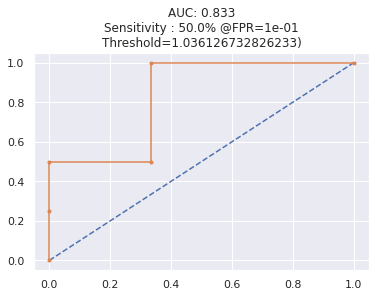

In [29]:
probs, yprob = compute_probs(build_embedding, X_test[:500,:,:,:,:], Y_test[:500])
fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr, thresholds, auc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[-0.13875982 -0.13382791  0.06637992 -0.04847086 -0.0578668  -0.04529008
  0.04401942  0.0943393   0.108431    0.03807433 -0.039698    0.03714535
  0.16332394 -0.02291363 -0.07173429 -0.14362934 -0.0938436   0.00515298
  0.14445952  0.00152413 -0.04746701 -0.03051526  0.05077294  0.03106732
  0.0306131   0.0017228  -0.1035117   0.10554155 -0.10073059  0.17037821
 -0.02901252 -0.0071150

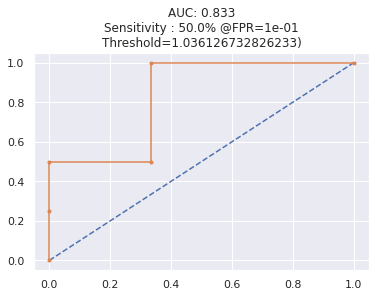

In [17]:
from scipy.spatial import distance

def compute_dist(a,b):
    return distance.cityblock(a,b)
    #return distance.correlation(a,b) -- NOT GOOD
    #return distance.cosine(a,b) -- NOT GOOD
    
    #return distance.euclidean(a,b)

    # Standard distance used 
    #return np.sum(np.square(a-b))

def compute_metrics(probs, yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no 
        instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
   
    return fpr, tpr, thresholds, auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes, num_frames, rows, cols, d))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = X_test[i,:,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))
    plt.show()
    
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=0.1
    _, idx = find_nearest(fpr, targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold)))
    # show the plot
    plt.show()
    
def compute_probs(network, X, Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m, num_frame, h, w, 1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    print(embeddings[1])
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for 
                # right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
               # print(probs[k])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs, y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

class call_back(tf.keras.callbacks.Callback):
    probs, yprob = compute_probs(build_embedding, X_test, Y_test)
    fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
    draw_roc(fpr, tpr, thresholds, auc)
   # draw_interdist(build_embedding, n_iteration)

In [ ]:
history = build_triplet.fit(x=triplet_generator_spoof(batch_size, X_train, Y_train), y=None, batch_size=batch_size, epochs=10, verbose=1, callbacks=None, 
                              validation_data=None, shuffle=True, class_weight=None, 
                              sample_weight=None, initial_epoch=0, steps_per_epoch=10, validation_steps=None)

In [ ]:
probs, yprob = compute_probs(build_embedding, X_test[:500,:,:,:,:], Y_test[:500])
fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr, thresholds, auc)

In [ ]:
n_iter = 2000
def train_my_network():
    print("Starting training process!!")
    print("-------------------------------------")
    t_start = time.time()
    n_iteration=0
    #dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
    for i in range(1, n_iter+1):
        train_gen = get_triplet_batch_spoof(batch_size, X_train, Y_train)
        val_gen = get_triplet_batch_spoof(batch_size, X_test, Y_test)
        loss = build_triplet.fit_generator(train_gen, verbose=1)
        n_iteration += 1
        if i % 100 == 0:
            print("\n ------------- \n")
            print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}"\
                  .format(i, (time.time()-t_start)/60.0,loss,n_iteration))
            probs, yprob = compute_probs(build_embedding, X_test[:500,:,:,:,:], Y_test[:500])
            fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
            draw_roc(fpr, tpr, thresholds, auc)
            draw_interdist(build_embedding, n_iteration)
           # print("Probability " + str(probs))
           # print("YProbs " + str(yprob))
            #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
            #draw_roc(fpr, tpr)

train_my_network()